# `r-lattice-data` Engineering

<div class="alert alert-block alert-success"><b>The purpose of this notebook is to facilitate Open Science and Open Data:</b> reproducible and replicable research </div>

The notebook walks the user through the creation of the [`r-lattice-data`](https://adriankriger.github.io/r-lattice-data/) assignment dataset; which investigates spatial autocorrelation. _(Is the connection between variables dependent on their spatial relationship (their location)? and how strongly are they connected?)_

Briefly; the dataset represents residential theft and burglaries ([SAPS SA](https://www.saps.gov.za/services/older_crimestats.php)), median property valuation ([City of Cape Town Open Data](https://odp-cctegis.opendata.arcgis.com/)), median income ([STATSSA](https://www.statssa.gov.za/) via [wazimap](https://wazimap.co.za/profiles/municipality-CPT-city-of-cape-town/)), among other variables, of suburbs within the City of Cape Town; South Africa.

The dataset _(the result of this notebook)_ and the **source data** are included in the [`SpatialStats_CoCT_HusCrm.gpkg`](https://github.com/AdrianKriger/r-lattice-data/tree/main/data)

The user is encouraged to work-through the notebook; include other datasets _(sexual asault, tree canopy, etc.)_ and test their own communities. i.e.: (execute the [`r-lattice-data`](https://adriankriger.github.io/r-lattice-data/) assignment).

In [59]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import topojson as tp

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

#- notebook runs fine. 
import warnings
warnings.filterwarnings('ignore')

**CoCT Prop. 2015 Valuation.** _--this dataset is no longer available on the [City of Cape Town Open Data](https://odp-cctegis.opendata.arcgis.com/) portal. It is however included in the [`.gpkg`]()_

In [2]:
#- read
propVal = gpd.read_file('SpatialStats_CoCT_HusCrm.gpkg', layer = 'CoCT_subValuation')
#- look
propVal.head(3)

,field_1,field_2,field_3,field_4,field_5,field_6,geometry
0,OFFICIAL_SUBURB,FREEHOLD PROPERTIES,None,None,None,None,None
1,None,NUM_RES_PROP,MED_LAND_EXTENT/m2,MED_TOT_BLD_AREA/m2,GV2012_VAL,GV2015_VAL,None
2,ACACIA PARK,None,None,None,None,None,None


**CoCT Official Suburbs.** _--this dataset is available on the [City of Cape Town Open Data](https://odp-cctegis.opendata.arcgis.com/datasets/cctegis::official-planning-suburbs/about) portal and is included in the [`.gpkg`]()_

In [3]:
#- read
subs = gpd.read_file('SpatialStats_CoCT_HusCrm.gpkg', layer = 'CoCT_suburbs')
#- sort
subs = subs.sort_values("OFC_SBRB_N")
#- look
subs.head(4)

,OBJECTID,OFC_SBRB_N,SHAPE_Leng,SHAPE_Area,geometry
775,776,AAN DE WIJNLANDEN ESTATE,4534.160406,5.137987e+05,"MULTIPOLYGON (((18.74257 -34.00599, 18.74257 -..."
559,560,ACACIA PARK,8813.434059,2.834563e+06,"MULTIPOLYGON (((18.52312 -33.90116, 18.52262 -..."
554,555,ADMIRALS PARK,2208.167370,2.140566e+05,"MULTIPOLYGON (((18.87932 -34.15212, 18.87912 -..."
471,472,ADRIAANSE,2887.830227,4.321643e+05,"MULTIPOLYGON (((18.59292 -33.94262, 18.59305 -..."


In [4]:
len(subs)

777

These two datasets originate from the same source. The City of Cape Town and we can see the `OFFICIAL_SUBURB` and `OFC_SBRB_N` are _**mostly the same**_. we can `.pd.merge()`.

However; I have **_looked_** at the contents of these and **we need to wrangle the data into an appropriate shape**. We want to transfer the values from `propVal` to `subs` (`.pd.merge()`) but although the names are common they do not always match. We need to change what we know.  

In [ ]:
propVal.drop(propVal.index[[0, 1]], inplace = True)
propVal.drop('geometry', axis = 1, inplace = True)
propVal.drop('field_5', axis = 1, inplace = True)
propVal.rename({'field_1': 'OFFICIAL_SUBURB', 
                'field_2': 'NUM_RES_PROP',
                'field_3': 'MED_LAND_EXTENT/m2', 
                'field_4': 'MED_TOT_BLD_AREA/m2',
                #'field_5': 'GV2012_VAL', 
                'field_6': 'GV2015VAL'}, axis = 1, inplace = True)

#- handle currency str(R) and decimal str(,)
propVal['GV2015VAL'] = propVal['GV2015VAL'].str.replace('R', '').str.replace(' ', '')#.astype(int)
propVal['MED_TOT_BLD_AREA/m2'] = propVal['MED_TOT_BLD_AREA/m2'].str.replace(',', '').str.replace(' ', '')
propVal['MED_LAND_EXTENT/m2'] = propVal['MED_LAND_EXTENT/m2'].str.replace(',', '').str.replace(' ', '')

#- change None to np.nan and columns to numeric
propVal.fillna(value = np.nan, inplace = True)
propVal['NUM_RES_PROP'] = pd.to_numeric(propVal['NUM_RES_PROP'])
propVal['MED_LAND_EXTENT/m2'] = pd.to_numeric(propVal['MED_LAND_EXTENT/m2'])
propVal['MED_TOT_BLD_AREA/m2'] = pd.to_numeric(propVal['MED_TOT_BLD_AREA/m2'])
propVal['GV2015VAL'] = pd.to_numeric(propVal['GV2015VAL'])

#- sum suburbs that and property val. areas that differ
#propVal.iloc[6] += propVal.iloc[7] #AMANDA GLEN - Bellville + AMANDA GLEN - Durbanville :border each other
#propVal.drop([7], inplace=True)
#propVal.iloc[352] += propVal.iloc[353] #KENRIDGE - Bellville + KENRIDGE  - Durbanville  :border each other
#propVal.drop([353], inplace=True)
#propVal.iloc[229] += propVal.iloc[230] #KALKFONTEIN 1 + KALKFONTEIN II                  :border each other
#propVal.drop([230], inplace=True)
#propVal.iloc[344] += propVal.iloc[345] #EVERSDAL - Bellville + EVERSDAL  - Durbanville  :border each other
#propVal.drop([345], inplace=True)

#- change names to match 
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('DIEPRIVER', 'DIEP RIVER')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('AMANDA GLEN - Bellville', 'AMANDA GLEN')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('KENRIDGE - Bellville', 'KENRIDGE')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('EVERSDAL - Bellville', 'EVERSDAL')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('KALKFONTEIN 1', 'KALKFONTEIN')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('BRENTWOOD PARK - Durbanville', 
                                                                    'BRENTWOOD PARK - DURBANVILLE')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('DIEPRIVER', 'DIEP RIVER')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('ENKANINI INFORMAL SETTLEMENT', 
                                                                    'ENKANINI')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('EVERSDAL - Bellville', 
                                                                    'EVERSDAL')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('SURREY', 'SURREY ESTATE')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('VANGUARD', 'VANGUARD ESTATE')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('ONVERWACHT', 'ONVERWACHT - THE STRAND')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('ONVERWACHT (Gordons Bay)', 
                                                                    "ONVERWACHT - GORDAN'S BAY")
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('PINATI', 'PINATI ESTATE')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('ZEEKOEIVLEI', 'ZEEKOEVLEI')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('ZONNEBLOEM', 'DISTRICT SIX')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('SCHOTSCHEKLOOF', 'BO-KAAP')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('VREDENBERG', 'VREDENBERG - BELVILLE')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('EKUPHUMULENI', 'EKUPHUMLENI')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('ROSEDALE', 'ROSEDALE - DURBANVILLE')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('PROTEAVALLEY', 'PROTEA VALLEY')
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('SIR LOWRYS PASS', "SIR LOWRY'S PASS")
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('SIR LOWRYS PASS VILLAGE CENTRE', 
                                                                    "SIR LOWRY'S PASS VILLAGE CENTRE")
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('SUNVALLEY', "SUN VALLEY")
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('WELCOME', 'WELCOME ESTATE')

#not sure about this one
propVal['OFFICIAL_SUBURB'] = propVal['OFFICIAL_SUBURB'].str.replace('WESTRIDGE', 
                                                                    'WESTRIDGE - MITCHELLS PLAIN') 


#- handle str(None) #np.nan or None or 0 or whatever you want.
#propVal['MED_TOT_BLD_AREA/m2'] = propVal['MED_TOT_BLD_AREA/m2'].map(lambda x : int(x) if x!= None else np.nan) 
#propVal['MED_LAND_EXTENT/m2'] = propVal['MED_LAND_EXTENT/m2'].map(lambda x : int(x) if x!= None else np.nan) 
#propVal['NUM_RES_PROP'] = propVal['NUM_RES_PROP'].map(lambda x : int(x) if x!= None else np.nan) 
#propVal['GV2015_VAL'] = propVal['GV2015_VAL'].map(lambda x : int(x) if x!= None else np.nan) 

Now we can `.pd.merge()`.

In [6]:
subVal = subs.merge(propVal, how = 'left', left_on = 'OFC_SBRB_N', right_on = 'OFFICIAL_SUBURB')
subVal.head(3)

,OBJECTID,OFC_SBRB_N,SHAPE_Leng,SHAPE_Area,geometry,OFFICIAL_SUBURB,NUM_RES_PROP,MED_LAND_EXTENT/m2,MED_TOT_BLD_AREA/m2,GV2015VAL
0,776,AAN DE WIJNLANDEN ESTATE,4534.160406,5.137987e+05,"MULTIPOLYGON (((18.74257 -34.00599, 18.74257 -...",NaN,NaN,NaN,NaN,NaN
1,560,ACACIA PARK,8813.434059,2.834563e+06,"MULTIPOLYGON (((18.52312 -33.90116, 18.52262 -...",ACACIA PARK,NaN,NaN,NaN,NaN
2,555,ADMIRALS PARK,2208.167370,2.140566e+05,"MULTIPOLYGON (((18.87932 -34.15212, 18.87912 -...",ADMIRALS PARK,401.0,235.0,111.0,760000.0


In [7]:
len(subVal)
#print(subVal[280:290])

777

In [8]:
subVal.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**`plot`**

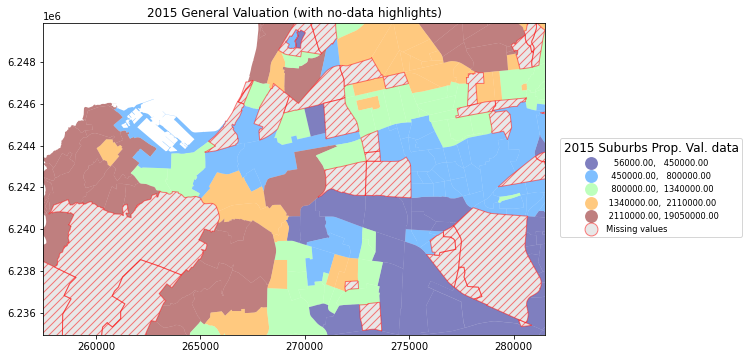

In [60]:
#- plot

#-- think of this as a type of box ((east, north, west, south) i.e.: I want to look in this general area
sel = (subVal.OFC_SBRB_N.isin(('SEA POINT', "MANENBERG", 'ATHLONE', 'BELVILLE', "TYGERVALLEY"))) #,
lonmin, latmin, lonmax, latmax = subVal[sel].total_bounds 

fig, ax = plt.subplots(1, 1, figsize = (9, 9))
#ax = fig.add_subplot(1, 1, 1)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes('right', pad = 0.1, size = '10%')

ax = subVal.plot(ax = ax, column = 'GV2015VAL', edgecolor = None, alpha = 0.5, 
            #cax = cax, 
            legend = True, 
            legend_kwds = {'loc': 'lower right', 'title_fontsize':'large', 'fontsize':'small',
                           'bbox_to_anchor':(1.2, 0.3, 0.2, 0.2),
                           'markerscale': 1.29},
            cmap = 'jet', scheme = 'quantiles',
            missing_kwds = {'color': 'lightgrey',
                           'edgecolor': 'red',
                           'hatch': '///',
                           'label': 'Missing values'})

#- label the nodata areas here
#nans = subVal[subVal['GV2015_VAL'].isnull()]
#nans.apply(lambda x: ax.annotate(text=x['OFC_SBRB_N'], xy=x.geometry.centroid.coords[0], ha='center', color='grey'), axis=1);

leg = ax.get_legend()
leg.set_title("2015 Suburbs Prop. Val. data")
#- zoom the plot to here
ax.axis([lonmin, lonmax, latmin, latmax])
# displaying the title
plt.title('2015 General Valuation (with no-data highlights)')#, y=0.79, x=0.51)
plt.show()

**SAPS Police Precincts** _--this dataset is available from the [South African Police Service](https://www.saps.gov.za/services/boundary.php)  and is included in the [`.gpkg`]()_

In [10]:
#- read
polPre = gpd.read_file('SpatialStats_CoCT_HusCrm.gpkg', layer = 'SAPS_precincts')
#- look
polPre.head(4)

,COMPNT_NM,CREATE_DT,VERSION,geometry
0,BOTSHABELO,20200310,1.2.4,"MULTIPOLYGON (((26.77137 -29.21403, 26.77330 -..."
1,KHUBUSIDRIFT,20200310,1.2.4,"MULTIPOLYGON (((27.72830 -32.53050, 27.72842 -..."
2,STUTTERHEIM,20200310,1.2.4,"MULTIPOLYGON (((27.50201 -32.44217, 27.49884 -..."
3,MOTHERWELL,20200310,1.2.4,"MULTIPOLYGON (((25.61061 -33.81772, 25.60713 -..."


In [11]:
#- the crs
polPre.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**SAPS Police Stations.** _--this dataset is available from the [South African Police Service](https://www.saps.gov.za/services/boundary.php)  and is included in the [`.gpkg`]()_

In [12]:
#- read
polSta = gpd.read_file('SpatialStats_CoCT_HusCrm.gpkg', layer = 'SAPS_stations')
polSta.head(4)

,COMPNT_NM,LOCATION_X,LOCATION_Y,CREATE_DT,VERSION,geometry
0,BOTSHABELO,26.71606,-29.23620,20200310,1.2.4,POINT (26.71606 -29.23620)
1,KHUBUSIDRIFT,27.62384,-32.56819,20200310,1.2.4,POINT (27.62384 -32.56819)
2,STUTTERHEIM,27.42741,-32.57118,20200310,1.2.4,POINT (27.42741 -32.57118)
3,MOTHERWELL,25.58419,-33.79664,20200310,1.2.4,POINT (25.58419 -33.79664)


In [13]:
#- the crs
polSta.crs
#polSta = polSta.sort_values("COMPNT_NM")
#print(polSta[300:350])

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**STATSSA Census Wards.** _--this dataset is available on the [City of Cape Town Open Data](https://odp-cctegis.opendata.arcgis.com/datasets/cctegis::wards/about) portal and is included in the [`.gpkg`]()_ 

In [14]:
#- read
cenWards = gpd.read_file('SpatialStats_CoCT_HusCrm.gpkg', layer = 'StatsSA_wards')
#- look
cenWards.head(4)

,OBJECTID,WARD_NAME,WARD_YEAR,geometry
0,538,1,2021,"MULTIPOLYGON (((2070517.326 -4013255.623, 2070..."
1,539,2,2021,"MULTIPOLYGON (((2070958.885 -4013973.530, 2071..."
2,540,3,2021,"MULTIPOLYGON (((2079101.693 -4014309.917, 2079..."
3,541,4,2021,"MULTIPOLYGON (((2059258.039 -4009706.536, 2059..."


In [15]:
#- the crs
cenWards.crs

<Derived Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

**harvest the SAPS precincts** (its the entire country) **that cover the City of Cape Town**

In [16]:
bound = subVal.unary_union
d = {'col': ['name'], 'geometry': [bound]}
bound = gpd.GeoDataFrame(d, crs="EPSG:4326")

sj = gpd.sjoin(left_df = polPre[['COMPNT_NM', 'geometry']], right_df = bound[['geometry']], 
               how = 'inner', predicate = 'intersects')
CoCT_polPre = polPre.loc[polPre['COMPNT_NM'].isin(sj['COMPNT_NM'])]

#CoCT_polPre = polPre.overlay(bound, how='intersection')
CoCT_polPre = CoCT_polPre.sort_values("COMPNT_NM")
CoCT_polPre.head(2)

,COMPNT_NM,CREATE_DT,VERSION,geometry
796,ATHLONE,20200310,1.2.4,"MULTIPOLYGON (((18.51082 -33.94948, 18.51146 -..."
1103,ATLANTIS,20200310,1.2.4,"MULTIPOLYGON (((18.53667 -33.52705, 18.54176 -..."


**similarly; harvest the SAPS stations** (its also the entire country) **that cover the City of Cape Town**

In [17]:
bound = CoCT_polPre.unary_union
d = {'col': ['name'], 'geometry': [bound]}
bound = gpd.GeoDataFrame(d, crs="EPSG:4326")

sj = gpd.sjoin(left_df = polSta[['COMPNT_NM', 'geometry']], right_df = bound[['geometry']], 
               how = 'inner', predicate = 'intersects')
CoCT_polSta = polSta.loc[polSta['COMPNT_NM'].isin(sj['COMPNT_NM'])]
#CoCT_polSta = polSta.overlay(bound, how='intersection')
CoCT_polSta = CoCT_polSta.sort_values("COMPNT_NM")
CoCT_polSta.head(2)

,COMPNT_NM,LOCATION_X,LOCATION_Y,CREATE_DT,VERSION,geometry
796,ATHLONE,18.50724,-33.96157,20200310,1.2.4,POINT (18.50724 -33.96157)
1103,ATLANTIS,18.49318,-33.56479,20200310,1.2.4,POINT (18.49318 -33.56479)


In [18]:
#- check the precincts match the stations
print(len(CoCT_polSta))
print(len(CoCT_polPre))

68
68


<AxesSubplot: >

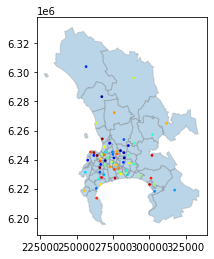

In [62]:
#- quick and dirty plot: stations over precincts
ax = CoCT_polPre.plot(alpha=0.3, edgecolor='grey')
CoCT_polSta.plot(ax = ax, cmap = 'jet', markersize = 3)#

**while we are here; harvest the STATSA wards that cover the City of Cape Town**

In [20]:
cenWards = cenWards.to_crs(4326)
bound = subVal.unary_union
d = {'col': ['name'], 'geometry': [bound]}
bound = gpd.GeoDataFrame(d, crs="EPSG:4326")

sj = gpd.sjoin(left_df = cenWards[['WARD_NAME', 'geometry']], right_df = bound[['geometry']], 
               how = 'inner', predicate = 'intersects')
CoCT_cenWards = cenWards.loc[cenWards['WARD_NAME'].isin(sj['WARD_NAME'])]
# convert column "a" of a DataFrame
CoCT_cenWards["WARD_NAME"] = pd.to_numeric(CoCT_cenWards["WARD_NAME"])
CoCT_cenWards = CoCT_cenWards.sort_values("WARD_NAME")
CoCT_cenWards.head(2)

,OBJECTID,WARD_NAME,WARD_YEAR,geometry
0,538,1,2021,"MULTIPOLYGON (((18.59977 -33.88414, 18.60023 -..."
1,539,2,2021,"MULTIPOLYGON (((18.60374 -33.88949, 18.60438 -..."


In [21]:
#len(CoCT_cenWards)
CoCT_cenWards.tail(3)

,OBJECTID,WARD_NAME,WARD_YEAR,geometry
113,651,114,2021,"MULTIPOLYGON (((18.66235 -33.98068, 18.66284 -..."
114,652,115,2021,"MULTIPOLYGON (((18.43252 -33.89832, 18.42866 -..."
115,653,116,2021,"MULTIPOLYGON (((18.63192 -34.04489, 18.63056 -..."


**`plot`** the suburbs and the precincts

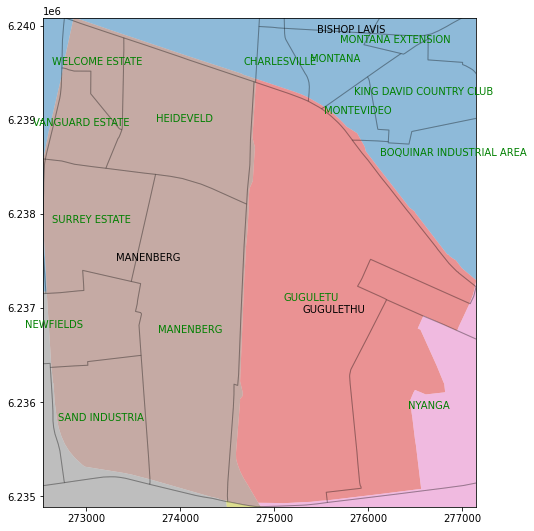

In [61]:
#- plot

sel = (CoCT_polPre.COMPNT_NM.isin(('MANENBERG', 'GUGULETHU')))
lonmin, latmin, lonmax, latmax = CoCT_polPre[sel].total_bounds #CoCT_polPre[CoCT_polPre['COMPNT_NM'] == 'MANENBERG'].total_bounds 

fig, ax = plt.subplots(figsize = (9, 9))
#ax = fig.add_subplot(1, 1, 1)

CoCT_polPre.plot(ax = ax, column= 'COMPNT_NM', edgecolor = None, alpha = 0.5, label = 'COMPNT_NM')
CoCT_polPre.apply(lambda x: ax.annotate(text=x['COMPNT_NM'], xy=x.geometry.centroid.coords[0], 
                                        ha='center'), axis=1);

subVal.plot(ax=ax, color = 'None', edgecolor = 'black', alpha = 0.2)

for idx, row in subVal.iterrows():
    plt.annotate(text=row['OFC_SBRB_N'], xy=row.geometry.centroid.coords[0], 
                 horizontalalignment='center', color='green')
#ax.axis(e)
ax.axis([lonmin, lonmax, latmin, latmax])
plt.show()

**We see here that suburbs are smaller than Police Precincts AND do not fit within** _(some cross)_ **their boundaries.** 

**We don't want to complicate matters but create an easy to execute solution. How do we do this?**

**We find all the Police Precincts that `.intersect()` a suburb and  simply `.mean` their values. While not `True` these values should give a pretty good idea of what is actually happening.**

In [ ]:
#-- we now have all the geometry covering CoCT but need them in the same projection: utm 34s (espg: 32734)

cenWards = cenWards.to_crs(32734)
topo = tp.Topology(cenWards, prequantize=False)#, winding_order='CCW_CW')
cenWards = topo.toposimplify(1).to_gdf()

CoCT_polPre = CoCT_polPre.to_crs(32734)
topo = tp.Topology(CoCT_polPre, prequantize=False)#, winding_order='CCW_CW')
CoCT_polPre = topo.toposimplify(1).to_gdf()
#CoCT_polPre['PolStation'] = CoCT_polPre['PolStation'].to_crs(32734)

CoCT_polSta = CoCT_polSta.to_crs(32734)
topo = tp.Topology(CoCT_polPre, prequantize=False)#, winding_order='CCW_CW')
CoCT_polPre = topo.toposimplify(1).to_gdf()

subVal = subVal.to_crs(32734)
topo = tp.Topology(subVal, prequantize=False)#, winding_order='CCW_CW')
subVal = topo.toposimplify(1).to_gdf()

In [25]:
#- check the units have changed
CoCT_polPre.head(3)

,geometry,COMPNT_NM,CREATE_DT,VERSION
796,"MULTIPOLYGON (((269966.171 6240653.964, 269239...",ATHLONE,20200310,1.2.4
1103,"MULTIPOLYGON (((271236.168 6287564.587, 270080...",ATLANTIS,20200310,1.2.4
642,"MULTIPOLYGON (((278180.853 6241145.239, 278182...",BELHAR,20200310,1.2.4


**Lets add the centre of the suburbs `(x, y)` as seperate columns to the `subVal.gdf`**

In [26]:
subVal['X'] = subVal['geometry'].centroid.x
subVal['Y'] = subVal['geometry'].centroid.y

In [27]:
#- add the police station to the precincts
CoCT_polPre['PoliceStation'] = CoCT_polSta['geometry']
#mer = pd.merge(CoCT_polPre, CoCT_polSta[['geometry']], left_on = 'COMPNT_NM', right_on = 'COMPNT_NM',how = 'outer')
CoCT_polPre.head(3)

,geometry,COMPNT_NM,CREATE_DT,VERSION,PoliceStation
796,"MULTIPOLYGON (((269966.171 6240653.964, 269239...",ATHLONE,20200310,1.2.4,POINT (269667.875 6239304.934)
1103,"MULTIPOLYGON (((271236.168 6287564.587, 270080...",ATLANTIS,20200310,1.2.4,POINT (267297.615 6283281.950)
642,"MULTIPOLYGON (((278180.853 6241145.239, 278182...",BELHAR,20200310,1.2.4,POINT (282710.909 6241238.875)


**We want to include additional variables that describe our data. `Area` and `Length` _(perimeter)_ of the `Police Precincts` and the distance from the centre of each `suburb` to the `Police Station` that serves it**

In [28]:
#- there might be a more efficient way to do this
data = []
dist = []
area = []
peri = []

for index, orig in subVal.iterrows():
    data2 = []
    dist2 = []
    area2 = []
    peri2 = []
    for index2, ref in CoCT_polPre.iterrows():
        if orig['geometry'].buffer(0).intersects(ref['geometry'].buffer(0)): 
            #- harvet the precinct name
            data2.append(ref['COMPNT_NM'])
            #- calculate distance from centre of suburb to the police station, area and length of a precinct
            dist2.append(orig['geometry'].centroid.distance(ref['PoliceStation']))
            #print(orig.geometry)#.distance(ref['PoliceStation']))
            area2.append(ref.geometry.area)
            peri2.append(ref.geometry.length)
            #break
        #break
    #break
    data.append(data2)
    dist.append(dist2)
    area.append(area2)
    peri.append(peri2)

In [29]:
#print(len(subVal))
#print(len(data))

In [30]:
#- add the new variables to the suburb.gdf
subVal['Station'] = pd.Series(data)
subVal['StationsDist'] = pd.Series(dist)
subVal['AVESTADist'] = subVal['StationsDist'].apply(np.mean)
subVal['PrecinctsArea'] = pd.Series(area)
subVal['AVAPREArea'] = subVal['PrecinctsArea'].apply(np.mean)
subVal['PrecinctsLen'] = pd.Series(peri)
subVal['AvePrecinctsLen'] = subVal['PrecinctsLen'].apply(np.mean)

subVal.head(2)
#CoCT_polPre.plot()

,geometry,OBJECTID,OFC_SBRB_N,SHAPE_Leng,SHAPE_Area,OFFICIAL_SUBURB,NUM_RES_PROP,MED_LAND_EXTENT/m2,MED_TOT_BLD_AREA/m2,GV2015VAL,X,Y,Station,StationsDist,AVESTADist,PrecinctsArea,AVAPREArea,PrecinctsLen,AvePrecinctsLen
0,"MULTIPOLYGON (((291525.146 6234882.716, 291415...",776,AAN DE WIJNLANDEN ESTATE,4534.160406,5.137987e+05,NaN,NaN,NaN,NaN,NaN,291191.94714,6.234420e+06,"[KLEINVLEI, STELLENBOSCH]","[3055.2262446575687, 13604.800887177007]",8330.013566,"[26648462.479252875, 376867651.08642346]",2.017581e+08,"[24674.257370602747, 144381.1457476814]",84527.701559
1,"MULTIPOLYGON (((270897.941 6246009.101, 270896...",560,ACACIA PARK,8813.434059,2.834563e+06,ACACIA PARK,NaN,NaN,NaN,NaN,270800.01976,6.246596e+06,"[GOODWOOD, KENSINGTON, MAITLAND, MILNERTON]","[4010.592536839889, 1789.2312958018001, 4667.7...",3344.735814,"[15287334.022337114, 6062179.348738552, 842933...",1.458929e+07,"[18820.679406607203, 13920.761472336622, 25721...",23640.659765


In [31]:
#subVal.head(4)

**Notice `AVESTADist`, `AVEPREArea` and `AvePrecintLen` where a suburb is served by more than one Precinct.**

**I choose to accept the solution.** 

**If you believe the solution is unrealistic and needs to change; you are welcome to raise and issue. I depend on you to help me improve.**

In [32]:
#- check the number of suburbs are the same we started with
len(subVal)

777

**SAPS Crime.** _I created the dataset myself with only the variables I want to test. `Residential robbery` and `residential burglary` harvested from the [Annual Crime Statistics 2021/2022 Station ten year stats SAPS.xls](https://www.saps.gov.za/services/older_crimestats.php). The original file is included in the [`.gpkg`]()_ 

In [33]:
sapsCrime = gpd.read_file('SpatialStats_CoCT_HusCrm.gpkg', layer = 'SAPS_crime')
sapsCrime.head(2)

,Station,RobberyResidential,BurglaryResidential,geometry
0,ATHLONE,17.0,501.0,None
1,ATLANTIS,10.0,495.0,None


In [34]:
sapsCrime.drop('geometry', axis = 1, inplace = True)
sapsCrime['CRIME'] = sapsCrime['RobberyResidential'] + sapsCrime['BurglaryResidential']
sapsCrime.head(5)

,Station,RobberyResidential,BurglaryResidential,CRIME
0,ATHLONE,17.0,501.0,518.0
1,ATLANTIS,10.0,495.0,505.0
2,BELHAR,9.0,352.0,361.0
3,BELLVILLE,29.0,1013.0,1042.0
4,BELLVILLE SOUTH,1.0,192.0,193.0


In [35]:
#- check the length is the same as the precincts and stations
len(sapsCrime)

68

In [36]:
#- match the crime variables to the suburbs
te = subVal.reset_index().explode('Station').merge(sapsCrime, how = 'left',
                                                   on='Station').set_index('index').rename_axis(None)
te = te.sort_values("OFC_SBRB_N")
te.head(2)

,geometry,OBJECTID,OFC_SBRB_N,SHAPE_Leng,SHAPE_Area,OFFICIAL_SUBURB,NUM_RES_PROP,MED_LAND_EXTENT/m2,MED_TOT_BLD_AREA/m2,GV2015VAL,X,Y,Station,StationsDist,AVESTADist,PrecinctsArea,AVAPREArea,PrecinctsLen,AvePrecinctsLen,RobberyResidential,BurglaryResidential,CRIME
0,"MULTIPOLYGON (((291525.146 6234882.716, 291415...",776,AAN DE WIJNLANDEN ESTATE,4534.160406,513798.70137,NaN,NaN,NaN,NaN,NaN,291191.94714,6.234420e+06,KLEINVLEI,"[3055.2262446575687, 13604.800887177007]",8330.013566,"[26648462.479252875, 376867651.08642346]",2.017581e+08,"[24674.257370602747, 144381.1457476814]",84527.701559,19.0,847.0,866.0
0,"MULTIPOLYGON (((291525.146 6234882.716, 291415...",776,AAN DE WIJNLANDEN ESTATE,4534.160406,513798.70137,NaN,NaN,NaN,NaN,NaN,291191.94714,6.234420e+06,STELLENBOSCH,"[3055.2262446575687, 13604.800887177007]",8330.013566,"[26648462.479252875, 376867651.08642346]",2.017581e+08,"[24674.257370602747, 144381.1457476814]",84527.701559,48.0,917.0,965.0


In [37]:
#- .groupby() each suburb and .mean() the values [when more than one precinct serves the suburb]
grp = te.groupby('OFC_SBRB_N')[['RobberyResidential', 'BurglaryResidential', 'CRIME']].mean().reset_index()
print(len(grp))

777


In [38]:
#- look
grp.head(5)

,OFC_SBRB_N,RobberyResidential,BurglaryResidential,CRIME
0,AAN DE WIJNLANDEN ESTATE,33.500000,882.000000,915.5
1,ACACIA PARK,26.500000,329.000000,355.5
2,ADMIRALS PARK,9.000000,234.000000,243.0
3,ADRIAANSE,15.333333,322.666667,338.0
4,AIRPORT,134.500000,453.500000,588.0


In [39]:
#- add the new variable to the suburbs
subVal['ROBRes'] = grp['RobberyResidential']
subVal['BUGRes'] = grp['BurglaryResidential']
subVal['CRIME'] = grp['CRIME']
#- look
subVal.head(3)

,geometry,OBJECTID,OFC_SBRB_N,SHAPE_Leng,SHAPE_Area,OFFICIAL_SUBURB,NUM_RES_PROP,MED_LAND_EXTENT/m2,MED_TOT_BLD_AREA/m2,GV2015VAL,X,Y,Station,StationsDist,AVESTADist,PrecinctsArea,AVAPREArea,PrecinctsLen,AvePrecinctsLen,ROBRes,BUGRes,CRIME
0,"MULTIPOLYGON (((291525.146 6234882.716, 291415...",776,AAN DE WIJNLANDEN ESTATE,4534.160406,5.137987e+05,NaN,NaN,NaN,NaN,NaN,291191.947140,6.234420e+06,"[KLEINVLEI, STELLENBOSCH]","[3055.2262446575687, 13604.800887177007]",8330.013566,"[26648462.479252875, 376867651.08642346]",2.017581e+08,"[24674.257370602747, 144381.1457476814]",84527.701559,33.5,882.0,915.5
1,"MULTIPOLYGON (((270897.941 6246009.101, 270896...",560,ACACIA PARK,8813.434059,2.834563e+06,ACACIA PARK,NaN,NaN,NaN,NaN,270800.019760,6.246596e+06,"[GOODWOOD, KENSINGTON, MAITLAND, MILNERTON]","[4010.592536839889, 1789.2312958018001, 4667.7...",3344.735814,"[15287334.022337114, 6062179.348738552, 842933...",1.458929e+07,"[18820.679406607203, 13920.761472336622, 25721...",23640.659765,26.5,329.0,355.5
2,"MULTIPOLYGON (((304475.062 6218934.812, 304506...",555,ADMIRALS PARK,2208.167370,2.140566e+05,ADMIRALS PARK,401.0,235.0,111.0,760000.0,304335.721363,6.219347e+06,[GORDONS BAY],[1403.8380387141265],1403.838039,[56236914.62510753],5.623691e+07,[68684.23613487242],68684.236135,9.0,234.0,243.0


**Median Household Income.** _--this dataset is [STATSA](https://www.statssa.gov.za/) census data available from [wazimap](https://wazimap.co.za/profiles/municipality-CPT-city-of-cape-town/) and is included in the [`.gpkg`]()_ 

In [40]:
#- read
income = gpd.read_file('SpatialStats_CoCT_HusCrm.gpkg', layer = 'Census2011_income')

#- look
income.head(2)

,geo_level,geo_code,geoid,name,total,No income,No income-Female,No income-Male,Not applicable,Not applicable-Female,Not applicable-Male,R 1 228 801 - R 2 457 600,R 1 228 801 - R 2 457 600-Female,R 1 228 801 - R 2 457 600-Male,R 1228801 - R 2457600,R 1228801 - R 2457600-Female,R 1228801 - R 2457600-Male,R 153601 - R 307200,R 153601 - R 307200-Female,R 153601 - R 307200-Male,R 153 801 - R 307 600,R 153 801 - R 307 600-Female,R 153 801 - R 307 600-Male,R 19201 - R 38400,R 19201 - R 38400-Female,R 19201 - R 38400-Male,R 19 601 - R 38 200,R 19 601 - R 38 200-Female,R 19 601 - R 38 200-Male,R 1 - R 4800,R 1 - R 4800-Female,R 1 - R 4800-Male,R 2 457 601 or more,R 2 457 601 or more-Female,R 2 457 601 or more-Male,R2457601 or more,R2457601 or more-Female,R2457601 or more-Male,R 307201 - R 614400,R 307201 - R 614400-Female,R 307201 - R 614400-Male,R 307 601 - R 614 400,R 307 601 - R 614 400-Female,R 307 601 - R 614 400-Male,R 38 201 - R 76 400,R 38 201 - R 76 400-Female,R 38 201 - R 76 400-Male,R 38401 - R 76800,R 38401 - R 76800-Female,R 38401 - R 76800-Male,R 4801 - R 9600,R 4801 - R 9600-Female,R 4801 - R 9600-Male,R 614 001 - R 1 228 800,R 614 001 - R 1 228 800-Female,R 614 001 - R 1 228 800-Male,R 614401- R 1228800,R 614401- R 1228800-Female,R 614401- R 1228800-Male,R 76 401 - R 153 800,R 76 401 - R 153 800-Female,R 76 401 - R 153 800-Male,R 76801 - R 153600,R 76801 - R 153600-Female,R 76801 - R 153600-Male,R 9601 - R 19200,R 9601 - R 19200-Female,R 9601 - R 19200-Male,R 9601 - R 19 600,R 9601 - R 19 600-Female,R 9601 - R 19 600-Male,Unspecified,Unspecified-Female,Unspecified-Male,geometry
0,ward,19100043,ward-19100043,b'City of Cape Town Ward 43 (19100043)',9858,877,251,626,0,0,0,None,None,None,38,3,35,2296,507,1789,None,None,None,1055,285,770,None,None,None,124,58,66,None,None,None,24,1,23,1271,165,1106,None,None,None,None,None,None,1307,390,917,160,61,99,None,None,None,190,20,170,None,None,None,1787,516,1271,729,323,406,None,None,None,0,0,0,None
1,municipality,CPT,municipality-CPT,b'City of Cape Town',1113237,157950,58524,99426,0,0,0,None,None,None,9877,1927,7950,128684,41793,86891,None,None,None,179742,74073,105669,None,None,None,31282,17145,14137,None,None,None,5152,1108,4044,93966,21760,72206,None,None,None,None,None,None,160185,64029,96156,45037,22380,22657,None,None,None,38375,6650,31725,None,None,None,142843,54692,88151,120071,61571,58500,None,None,None,73,10,63,None


**We need to wrangle and cull some of this data because its more than we need**

In [41]:
income = income[income['geo_level'] == 'ward']

income.drop('geo_level', axis = 1, inplace = True)
income.drop('name', axis = 1, inplace = True)
income.drop('geoid', axis = 1, inplace = True)
income.drop('total', axis = 1, inplace = True)
#income.drop('No income', axis = 1, inplace = True)
income.drop('Not applicable', axis = 1, inplace = True)
#income.drop('Unspecified', axis = 1, inplace = True)

income['geo_code'] = income['geo_code'].str[4:].astype(int)

income.columns = income.columns.str.replace("R", "")

income.drop(income.filter(regex='Male').columns, axis=1, inplace=True)
income.drop(income.filter(regex='Female').columns, axis=1, inplace=True)
income = income.sort_values("geo_code")
income = income.set_index('geo_code')#.T
#income = income.T
income.rename({'2457601 or more': '2500000'}, axis = 1, inplace = True)
income.rename({'No income': '0'}, axis = 1, inplace = True)
income.rename({'Unspecified': '00'}, axis = 1, inplace = True)
income.dropna(axis = 1, how = 'all', inplace = True)
income = income.T
#income = income.sort_index()
income.apply(pd.to_numeric)
income.head(3)

geo_code,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116
0,815,1026,735,1344,569,2688,741,918,655,972,740,669,1549,1220,1091,1226,1006,1382,2167,1829,568,776,1167,1230,1366,1234,570,682,870,685,742,1641,2708,2321,2579,2004,1409,722,1786,2240,...,969,1098,1158,2530,1003,849,1447,1267,2168,2596,1802,3591,2728,1527,1643,1187,1986,992,3598,1899,1371,1678,1783,1095,2959,1060,935,4190,1214,3067,759,2233,992,959,1270,639,778,1930,1273,632
1228801 - 2457600,305,104,74,177,84,10,40,118,23,38,82,13,12,84,298,23,30,10,27,10,338,32,473,14,13,44,50,14,18,14,14,19,15,12,2,3,10,4,2,8,...,374,17,7,8,12,2,53,249,35,17,12,4,6,1,3,15,7,8,9,6,10,6,11,65,9,109,117,13,187,13,181,17,12,13,9,262,172,6,251,15
153601 - 307200,2028,2330,2341,1720,1757,585,1695,2516,908,1679,2222,904,434,1639,1850,1461,1696,328,1078,334,1773,1158,2384,361,794,1982,1673,628,789,1109,626,788,164,155,301,152,143,270,111,198,...,2071,1590,735,249,1363,506,1191,1970,1086,545,107,253,88,97,146,1009,199,492,148,188,297,222,302,1840,130,2504,2448,158,1300,330,2583,958,630,575,1262,1857,2476,153,2256,1149


**Now we have want we want.** Wards / tracks along the top with the income ranges down the left.

We now calculate a median income for a census track / ward. We follow the example set on [wazimap](https://wazimap.co.za/help#faq-average-hh-income). The centre of the median range for the ward / tract is the number we want.

In [42]:
#- calc. median

s = income.index.to_series().str.split('\s*-\s*', expand=True).astype(float).mean(axis=1)

def median_(val, freq):
    ord = np.argsort(val)
    cdf = np.cumsum(freq[ord])
    return val[ord][np.searchsorted(cdf, cdf[-1] // 2)]

income.loc['median'] = income.apply(lambda col: median_(s, col))
#- for some reason there is a column that repeats. I don't know why.
income = income.loc[:, ~income.T.duplicated(keep = 'last')]

In [43]:
print(income.head(16))

geo_code                  1         2         3    ...      114       115      116
0                       815.0    1026.0     735.0  ...   1930.0    1273.0    632.0
 1228801 -  2457600     305.0     104.0      74.0  ...      6.0     251.0     15.0
 153601 -  307200      2028.0    2330.0    2341.0  ...    153.0    2256.0   1149.0
 19201 -  38400         408.0     642.0     505.0  ...   2215.0     659.0   1006.0
 1 -  4800               28.0      38.0      31.0  ...    497.0      80.0    106.0
2500000                 129.0      67.0      81.0  ...      4.0     157.0     17.0
 307201 -  614400      2044.0    1903.0    1775.0  ...     44.0    1847.0    494.0
 38401 -   76800        613.0    1202.0     944.0  ...   1260.0    1231.0   1394.0
 4801 -  9600            52.0      56.0      60.0  ...    691.0     124.0    207.0
 614401-  1228800      1254.0     627.0     528.0  ...      6.0     793.0     56.0
 76801 -  153600       1305.0    1943.0    1741.0  ...    510.0    2022.0   1442.0
 960

**The bottom `row` is what we want**

In [44]:
m = income.iloc[-1].reset_index()#.tolist()
len(m)

116

In [45]:
#- add the median to the wards / tracks
cenWards['INCOME'] = m['median']#income.iloc[-1]
#- look
cenWards.head(3)

,geometry,OBJECTID,WARD_NAME,WARD_YEAR,INCOME
0,"MULTIPOLYGON (((277982.903 6247645.016, 278048...",538,1,2021,230400.5
1,"MULTIPOLYGON (((281201.182 6247803.848, 281014...",539,2,2021,115200.5
2,"MULTIPOLYGON (((284456.844 6244933.227, 285002...",540,3,2021,230400.5


In [46]:
#- look
cenWards.tail(2)

,geometry,OBJECTID,WARD_NAME,WARD_YEAR,INCOME
114,"MULTIPOLYGON (((266284.237 6245189.716, 266259...",652,115,2021,115200.5
115,"MULTIPOLYGON (((281465.445 6229293.881, 280769...",653,116,2021,57600.5


**Number Bachelors Degrees.** _--this dataset is [STATSA](https://www.statssa.gov.za/) census data available from [wazimap](https://wazimap.co.za/profiles/municipality-CPT-city-of-cape-town/) and is included in the [`.gpkg`]()_

In [47]:
#- read
bach = gpd.read_file('SpatialStats_CoCT_HusCrm.gpkg', layer = 'Census2011_bachelor')

#- look
bach.head(2)

,geo_level,geo_code,geoid,name,total,Bachelors Degree,Bachelors Degree and Post graduate Diploma,Certificate with Grade 12 / Std 10,Certificate with less than Grade 12 / Std 10,Diploma with Grade 12 / Std 10,Diploma with less than Grade 12 / Std 10,Gade 0,Grade 10 / Std 8 / Form 3,Grade 11 / Std 9 / Form 4,Grade 12 / Std 10 / Form 5,Grade 1 / Sub A,Grade 2 / Sub B,Grade 3 / Std 1/ABET 1Kha Ri Gude;SANLI,Grade 4 / Std 2,Grade 5 / Std 3/ABET 2,Grade 6 / Std 4,Grade 7 / Std 5/ ABET 3,Grade 8 / Std 6 / Form 1,Grade 9 / Std 7 / Form 2/ ABET 4,Higher Degree Masters / PhD,Higher Diploma,Honours degree,N4 / NTC 4,N5 /NTC 5,N6 / NTC 6,No schooling,Not applicable,NTC III /N3/ NIC/ V Level 4,NTC II / N2/ NIC/ V Level 3,NTC I / N1/ NIC/ V Level 2,Other,Post Higher Diploma Masters; Doctoral Diploma,Unspecified,geometry
0,ward,19100046,ward-19100046,b'City of Cape Town Ward 46 (19100046)',20309,688,151,177,18,392,50,72,2662,1263,6347,84,102,163,321,442,614,1108,2143,1518,152,452,238,33,33,49,279,409,54,36,33,120,106,0,None
1,municipality,CPT,municipality-CPT,b'City of Cape Town',2510331,75333,25384,41731,5225,70626,8506,7424,299812,240552,727822,11185,15045,21262,35119,44676,62922,113003,199232,178417,30131,84301,35463,6463,4917,7787,42954,65396,9843,6722,6335,13434,13309,0,None


**Similarly; we need to wrangle and cull some of this data because its more than we need**

In [48]:
bach = bach[bach['geo_level'] == 'ward']

bach.drop('geo_level', axis = 1, inplace = True)
bach.drop('name', axis = 1, inplace = True)
bach.drop('geoid', axis = 1, inplace = True)
bach['geo_code'] = bach['geo_code'].str[4:].astype(int)

bach = bach.sort_values("geo_code")
bach = bach.set_index('geo_code')#.T
bach = bach.T

In [49]:
#- look
bach.head(2)

geo_code,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116
total,20691,23329,20370,23484,19079,23094,18902,21980,21974,22271,24308,22303,28196,24602,17344,26612,26123,16025,31690,25634,16909,20580,22024,19332,25693,27311,15717,22419,23748,23459,21645,27064,24443,22720,24797,19422,14417,15329,18601,22890,...,18366,22803,27183,22663,25658,25277,18128,25520,22679,24905,16583,27337,20572,14155,20322,19052,21943,20225,25719,19768,17166,20943,25497,23694,22982,20403,18911,24566,22350,32791,18838,25804,20517,16498,23642,16547,20771,16063,25851,19994
Bachelors Degree,1637,1322,1001,1378,829,177,527,1341,423,547,1409,117,52,690,1908,243,275,152,399,73,1922,565,1948,82,268,734,678,73,59,174,185,73,69,78,160,44,32,155,46,67,...,2304,225,81,111,117,44,791,1728,414,208,50,102,45,49,68,411,76,206,94,54,149,100,61,668,76,1172,1213,62,1056,99,1577,314,84,146,261,1631,1480,69,2031,416


**Now we have want we want.** Wards / tracks along the top with the number of Bachelor Degrees each following along.

In [50]:
b = bach.loc['Bachelors Degree'].reset_index()#.tolist()
len(b)

117

In [51]:
#b

In [52]:
#- add the bachelors to the wards / tracks
cenWards['BACHELORS'] = b['Bachelors Degree']#income.iloc[-1]

cenWards.head(3)

,geometry,OBJECTID,WARD_NAME,WARD_YEAR,INCOME,BACHELORS
0,"MULTIPOLYGON (((277982.903 6247645.016, 278048...",538,1,2021,230400.5,1637
1,"MULTIPOLYGON (((281201.182 6247803.848, 281014...",539,2,2021,115200.5,1322
2,"MULTIPOLYGON (((284456.844 6244933.227, 285002...",540,3,2021,230400.5,1001


**We do the same we did with the Suburbs and the Police Precincts.** 

**We find all the Census wards that `.intersect()` a suburb and  simply `.mean` their values. While not `True` these values should give a pretty good idea of what is actually happening.**

In [53]:
#- there might be a more efficient way to do this
data = []
inc = []
bac = []

for index, orig in subVal.iterrows():
    data2 = []
    inc2 = []
    bac2 = []
    for index2, ref in cenWards.iterrows():
        if orig['geometry'].buffer(0).intersects(ref['geometry'].buffer(0)): 
            #- harvet the precinct name
            data2.append(ref['WARD_NAME'])
            #- calculate distance from centre of suburb to the police station, area and length of a precinct
            #dist2.append(orig['geometry'].centroid.distance(ref['PoliceStation']))
            #print(orig.geometry)#.distance(ref['PoliceStation']))
            inc2.append(ref['INCOME'])
            bac2.append(ref['BACHELORS'])
            #break
        #break
    #break
    data.append(data2)
    inc.append(inc2)
    bac.append(bac2)

In [54]:
#- add the new variables to the gdf
subVal['WARD_NAME'] = pd.Series(data) 
#subVal['WARD_NAME'] = subVal['WARD_NAME'].apply(lambda x: x.apply(lambda x: ','.join(map(str, x))))

subVal['MEDINC'] = pd.Series(inc)
subVal['AVMEDINC'] = subVal['MEDINC'].apply(np.mean)
#subVal['MEDINC'] = subVal['MEDINC'].apply(lambda x: x.apply(lambda x: ','.join(map(str, x))))

subVal['BACH'] = pd.Series(bac)
subVal['AVBACH'] = subVal['BACH'].apply(np.mean)
#subVal['BACH'] = subVal['BACH'].apply(lambda x: x.apply(lambda x: ','.join(map(str, x))))

subVal.head(2)

,geometry,OBJECTID,OFC_SBRB_N,SHAPE_Leng,SHAPE_Area,OFFICIAL_SUBURB,NUM_RES_PROP,MED_LAND_EXTENT/m2,MED_TOT_BLD_AREA/m2,GV2015VAL,X,Y,Station,StationsDist,AVESTADist,PrecinctsArea,AVAPREArea,PrecinctsLen,AvePrecinctsLen,ROBRes,BUGRes,CRIME,WARD_NAME,MEDINC,AVMEDINC,BACH,AVBACH
0,"MULTIPOLYGON (((291525.146 6234882.716, 291415...",776,AAN DE WIJNLANDEN ESTATE,4534.160406,5.137987e+05,NaN,NaN,NaN,NaN,NaN,291191.94714,6.234420e+06,"[KLEINVLEI, STELLENBOSCH]","[3055.2262446575687, 13604.800887177007]",8330.013566,"[26648462.479252875, 376867651.08642346]",2.017581e+08,"[24674.257370602747, 144381.1457476814]",84527.701559,33.5,882.0,915.5,[14],[57600.5],57600.5,[690],690.0
1,"MULTIPOLYGON (((270897.941 6246009.101, 270896...",560,ACACIA PARK,8813.434059,2.834563e+06,ACACIA PARK,NaN,NaN,NaN,NaN,270800.01976,6.246596e+06,"[GOODWOOD, KENSINGTON, MAITLAND, MILNERTON]","[4010.592536839889, 1789.2312958018001, 4667.7...",3344.735814,"[15287334.022337114, 6062179.348738552, 842933...",1.458929e+07,"[18820.679406607203, 13920.761472336622, 25721...",23640.659765,26.5,329.0,355.5,"[55, 56]","[115200.5, 57600.5]",86400.5,"[2249, 1430]",1839.5


We need to clean up before we can save the result as a `shapefile` layer to the existing `.geopackage`

In [55]:
#- there might be a more efficient way to do this

# Iterate through each row and join elements into a comma-separated string
for index, row in subVal.iterrows():
    sta = row['Station']
    staD = row['StationsDist']
    preA = row['PrecinctsArea']
    preL = row['PrecinctsLen']
    war = row['WARD_NAME']
    medi = row['MEDINC']
    bat = row['BACH']
    cse = ', '.join(map(str, sta))
    csei = ', '.join(map(str, staD))
    cseii = ', '.join(map(str, preA))
    cseiii = ', '.join(map(str, preL))
    cseiv = ', '.join(map(str, war))
    csev = ', '.join(map(str, bat))
    subVal.at[index, 'STA'] = cse
    subVal.at[index, 'STAD'] = csei
    subVal.at[index, 'PREA'] = cseii
    subVal.at[index, 'PREL'] = cseiii
    subVal.at[index, 'WARD'] = cseiv
    subVal.at[index, 'BACH'] = csev
    
# Drop the original column if needed
subVal.drop('Station', axis=1, inplace=True)
subVal.drop('StationsDist', axis=1, inplace=True)
subVal.drop('PrecinctsArea', axis=1, inplace=True)
subVal.drop('PrecinctsLen', axis=1, inplace=True)
subVal.drop('WARD_NAME', axis=1, inplace=True)
subVal.drop('MEDINC', axis=1, inplace=True)
#subVal.drop('BACH', axis=1, inplace=True)

In [56]:
#- look
subVal.head(2)

,geometry,OBJECTID,OFC_SBRB_N,SHAPE_Leng,SHAPE_Area,OFFICIAL_SUBURB,NUM_RES_PROP,MED_LAND_EXTENT/m2,MED_TOT_BLD_AREA/m2,GV2015VAL,X,Y,AVESTADist,AVAPREArea,AvePrecinctsLen,ROBRes,BUGRes,CRIME,AVMEDINC,BACH,AVBACH,STA,STAD,PREA,PREL,WARD
0,"MULTIPOLYGON (((291525.146 6234882.716, 291415...",776,AAN DE WIJNLANDEN ESTATE,4534.160406,5.137987e+05,NaN,NaN,NaN,NaN,NaN,291191.94714,6.234420e+06,8330.013566,2.017581e+08,84527.701559,33.5,882.0,915.5,57600.5,690,690.0,"KLEINVLEI, STELLENBOSCH","3055.2262446575687, 13604.800887177007","26648462.479252875, 376867651.08642346","24674.257370602747, 144381.1457476814",14
1,"MULTIPOLYGON (((270897.941 6246009.101, 270896...",560,ACACIA PARK,8813.434059,2.834563e+06,ACACIA PARK,NaN,NaN,NaN,NaN,270800.01976,6.246596e+06,3344.735814,1.458929e+07,23640.659765,26.5,329.0,355.5,86400.5,"2249, 1430",1839.5,"GOODWOOD, KENSINGTON, MAITLAND, MILNERTON","4010.592536839889, 1789.2312958018001, 4667.73...","15287334.022337114, 6062179.348738552, 8429338...","18820.679406607203, 13920.761472336622, 25721....","55, 56"


In [57]:
subVal.describe()

,OBJECTID,SHAPE_Leng,SHAPE_Area,NUM_RES_PROP,MED_LAND_EXTENT/m2,MED_TOT_BLD_AREA/m2,GV2015VAL,X,Y,AVESTADist,AVAPREArea,AvePrecinctsLen,ROBRes,BUGRes,CRIME,AVMEDINC,AVBACH
count,777.000000,777.000000,7.770000e+02,635.000000,635.000000,635.000000,6.350000e+02,777.000000,7.770000e+02,777.000000,7.770000e+02,777.000000,777.000000,777.000000,777.000000,777.000000,777.000000
mean,389.000000,6148.798752,3.180585e+06,931.190551,3186.505512,462.042520,1.497628e+06,282980.296369,6.240142e+06,2719.015829,7.075055e+07,39913.749409,31.172088,673.453376,704.625464,127985.538359,781.818193
std,224.444871,11950.137826,2.122474e+07,1493.870729,37638.903767,836.067238,1.790661e+06,11873.955896,1.214015e+04,2176.284430,7.689552e+07,22498.530095,21.692694,277.329782,285.473503,89263.397752,571.517857
min,1.000000,590.873794,1.781416e+04,1.000000,36.000000,20.000000,5.600000e+04,254493.152771,6.205787e+06,66.134867,5.938870e+06,9348.958808,0.000000,0.000000,0.000000,14400.500000,44.000000
25%,195.000000,2490.185828,2.856197e+05,152.000000,285.500000,102.500000,4.900000e+05,274964.252039,6.230033e+06,1525.766190,1.850382e+07,22473.288576,17.500000,401.000000,428.000000,57600.500000,270.000000
50%,389.000000,3923.666753,6.752163e+05,407.000000,496.000000,188.000000,1.050000e+06,282973.949447,6.241387e+06,2299.388775,3.131227e+07,32286.797658,28.000000,700.000000,733.500000,115200.500000,716.500000
75%,583.000000,5969.301815,1.448977e+06,1022.000000,991.500000,288.500000,1.900000e+06,288651.231346,6.247978e+06,3253.862771,1.075569e+08,62382.178599,35.500000,978.500000,1012.000000,187200.500000,1233.000000
max,777.000000,179726.268619,4.033417e+08,18683.000000,944565.000000,6655.000000,1.905000e+07,308765.765429,6.288870e+06,24072.590957,5.077862e+08,128913.944943,156.500000,1177.000000,1220.000000,460800.500000,2511.000000


In [58]:
subVal.to_file('SpatialStats_CoCT_HusCrm.gpkg', layer = 'LatticeDataR', driver = 'GPKG')

C:\Users\EstelleSK\miniconda3\envs\osm3D_vc01\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
